In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# PARAMETERS
meter = 1
year = 365*24*3600
S0 = 35.0
DeltaT0 = -10.0        
alpha = 0.2
beta = 0.8
k = 1e10
area = (50000.0e3)**2
depth = 4000
V = area*depth
Sv = 1.e9
y0 = [1.0]

time_max = 75000*year
Fs_to_m_per_year = S0*area/year

# FORCING FUNCTIONS
def Fs_func(time, time_max, forcing_type):
    FW_min = -5
    FW_max = 5
    if forcing_type == "s":
        flux = (FW_max - FW_min) * np.sin(6 * np.pi * time / time_max)
    else:
        flux = 2.5*(FW_max - FW_min)*time/time_max * np.sin(6 * np.pi * time / time_max)
    return flux * area * S0 / year 

# Temperature varies linearly
def DeltaT_func(time, time_max):
    amp_T = 1.0/2.0  # K, amplitude of temperature variation
    DeltaT = DeltaT0 + amp_T*time/time_max
    return DeltaT

# AMOC function
def q(DeltaT, DeltaS):
    return k * (-alpha * DeltaT + beta * DeltaS)


# RHS for ΔS ODE
def rhs_S(time, DeltaS, time_max, forcing_type):
    DeltaT = DeltaT_func(time, time_max)
    rhs = -(2 * np.abs(q(DeltaT, DeltaS)) * DeltaS + 2*Fs_func(time, time_max, forcing_type))
    return rhs / V

In [3]:
def get_data(forcing_type):
    teval = np.arange(0, time_max, time_max/100000)
    tspan = (teval[0], teval[-1])

    sol = solve_ivp(fun=lambda time, DeltaS: rhs_S(time, DeltaS, time_max, forcing_type),
                t_span=tspan, y0=y0, t_eval=teval)

    Time = sol.t
    DeltaS = sol.y[0,:]

    # Compute ΔT and q over time
    DeltaT_dynamic = DeltaT_func(Time, time_max)
    FWplot = np.array([Fs_func(t, time_max, forcing_type) for t in Time])
    qplot = q(DeltaT_dynamic, DeltaS)
    
    input_data = np.column_stack((Time/year/1000, DeltaS, DeltaT_dynamic, FWplot))
    output_data = np.where(qplot < 0, 0, 1)
    
    return input_data, output_data, qplot

In [4]:
def plot_data(forcing_type):
    input_data, output_data, qplot = get_data(forcing_type)
    Time = input_data[:, 0]
    FWplot = input_data[:, 3]
    DeltaS = input_data[:, 1]
    DeltaT_dynamic = input_data[:, 2]
    plt.figure(figsize=(16,4), dpi=200)

    # Fs over time
    plt.subplot(1,4,1)
    plt.plot(Time/year/1000, FWplot/Fs_to_m_per_year, 'b-', markersize=1)
    plt.plot(Time/year/1000, 0*Time, 'k--', dashes=(10, 5), linewidth=0.5)
    plt.xlabel('time (kyr)')
    plt.ylabel('$F_s$ (m/yr)')
    plt.title('(a) Freshwater forcing')

    # q over time
    plt.subplot(1,4,2)
    plt.plot(Time/year/1000, qplot/Sv, 'b-', markersize=1)
    plt.plot(Time/year/1000, 0*Time, 'k--', dashes=(10, 5), lw=0.5)
    plt.xlabel('time (kyr)')
    plt.ylabel('$q$ (Sv)')
    plt.title('(b) AMOC transport $q$')

    # ΔS and ΔT over time
    plt.subplot(1,4,3)
    plt.plot(Time/year/1000, DeltaS, 'b-', label='$\Delta S$')
    plt.plot(Time/year/1000, DeltaT_dynamic, 'r--', label='$\Delta T$')
    plt.title('(c) ΔS and ΔT vs time')
    plt.xlabel('time (kyr)')
    plt.ylabel('ΔS / ΔT')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.plot(FWplot/Fs_to_m_per_year, qplot/Sv, 'b-')
    plt.plot(FWplot/Fs_to_m_per_year, 0*FWplot, 'k--', dashes=(10, 5), linewidth=0.5)
    plt.xlabel('$F_s$ (m/yr)');
    plt.ylabel('$q$ (Sv)');
    plt.title('(d) Hysteresis');

    plt.tight_layout()
    plt.show()

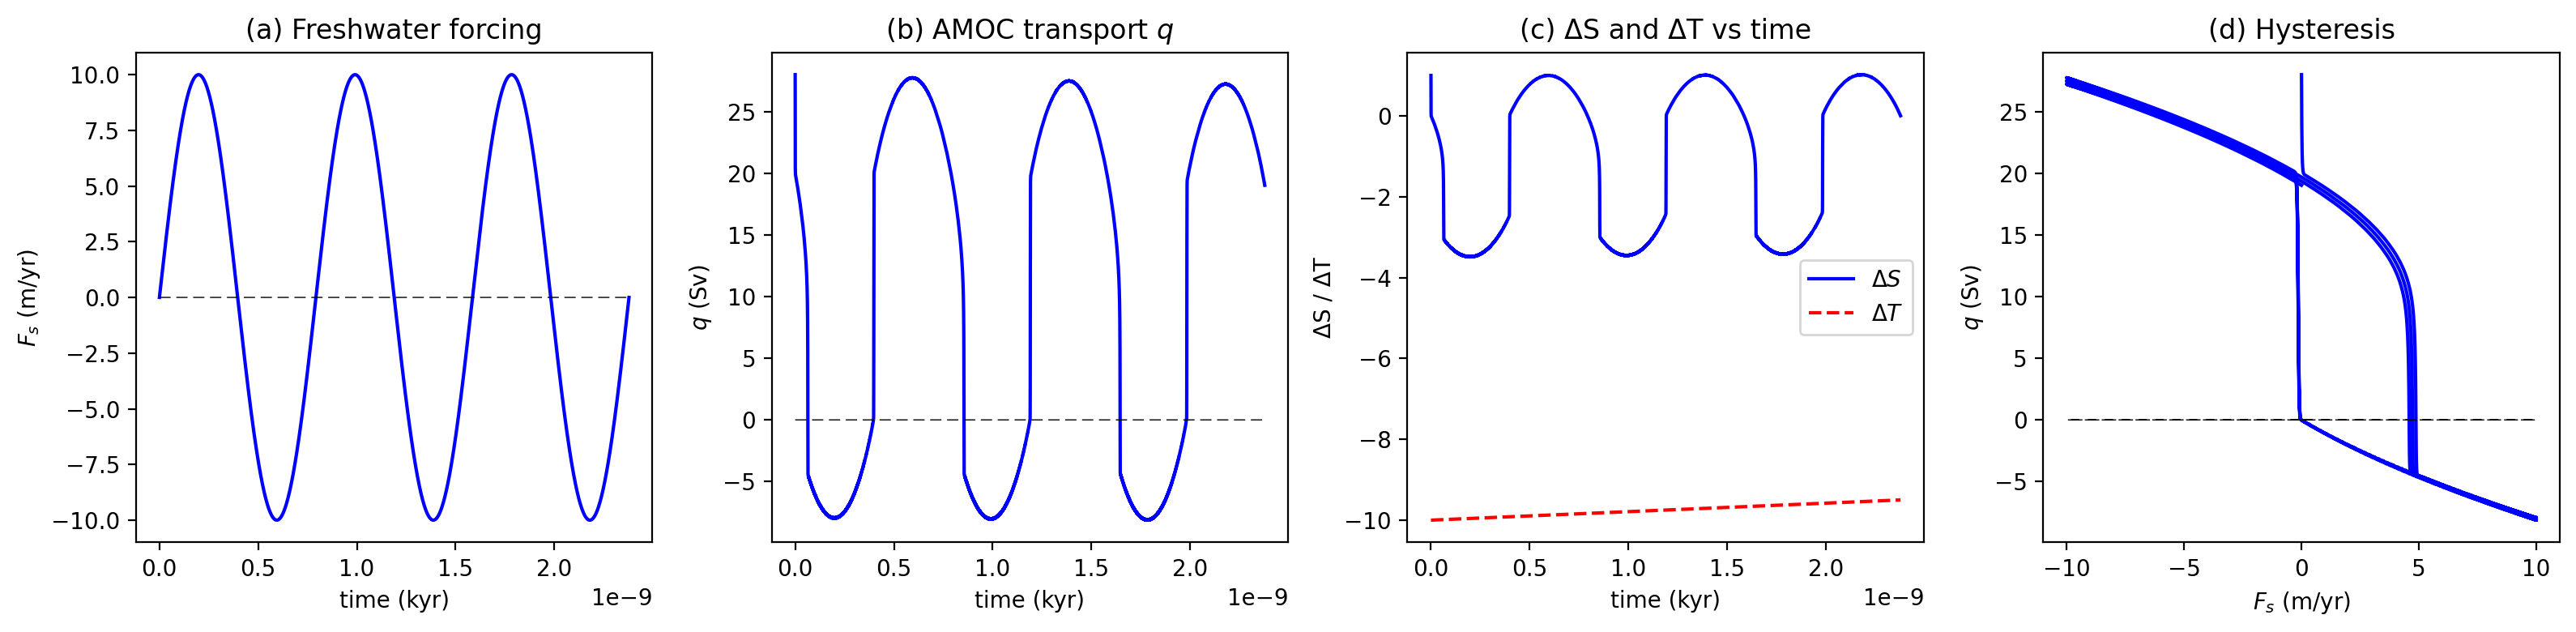

In [5]:
plot_data("s")

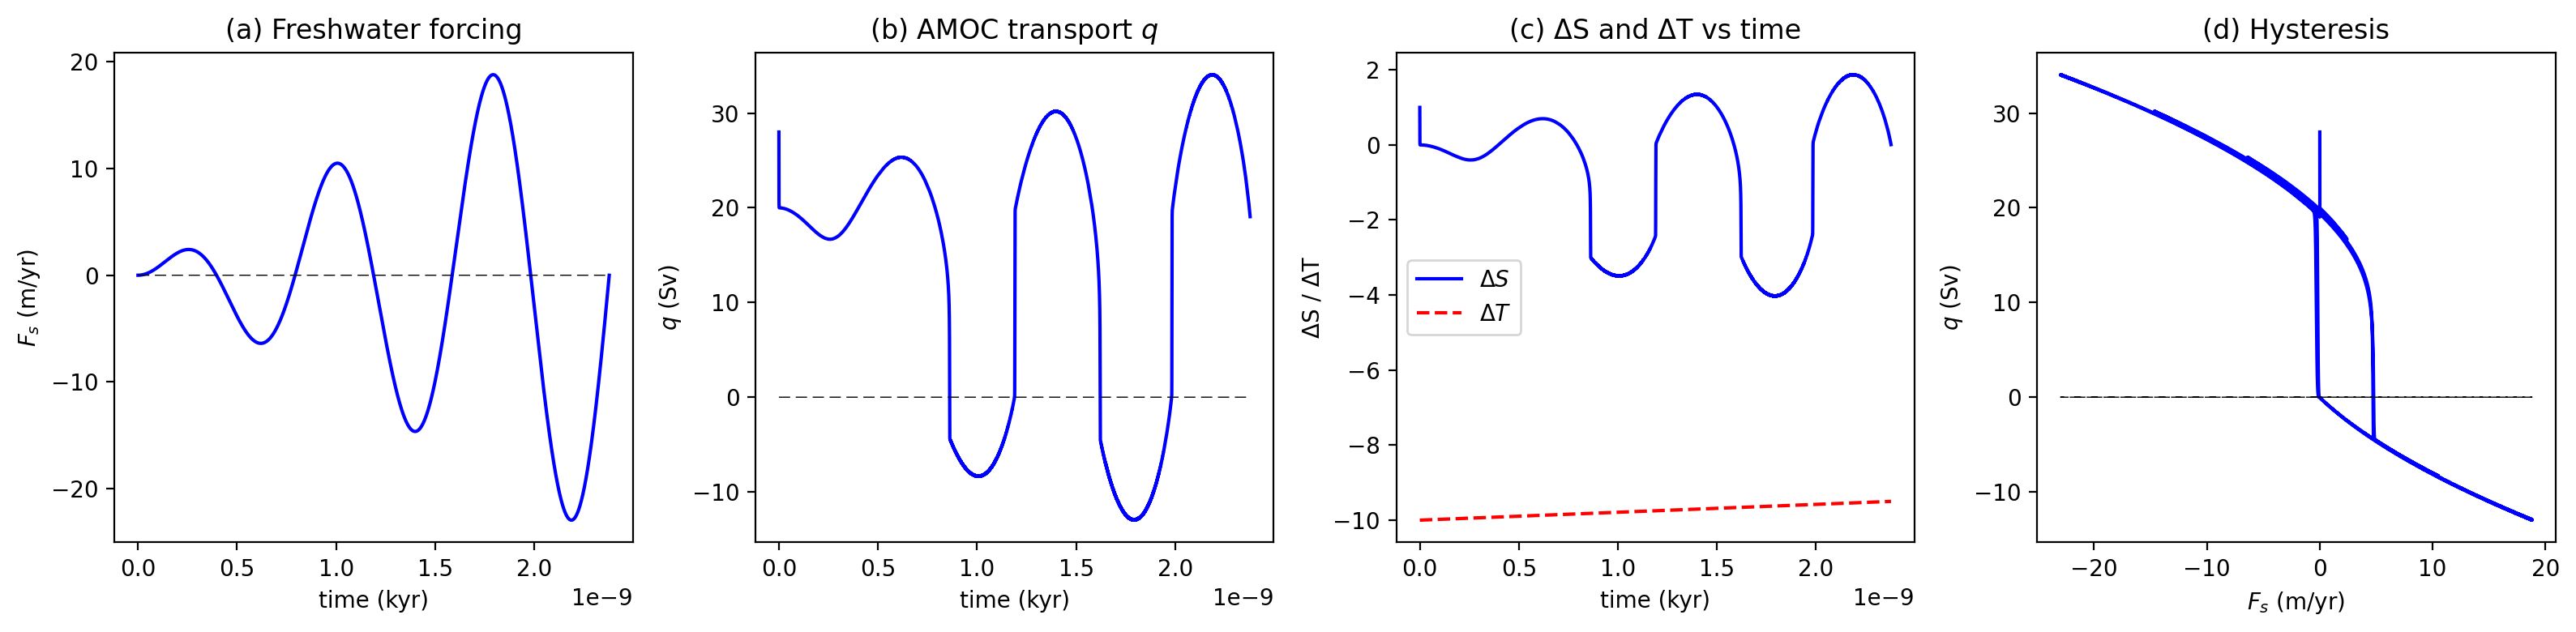

In [24]:
plot_data("ns")

In [41]:
input_data, output_data, qplot = get_data("s")

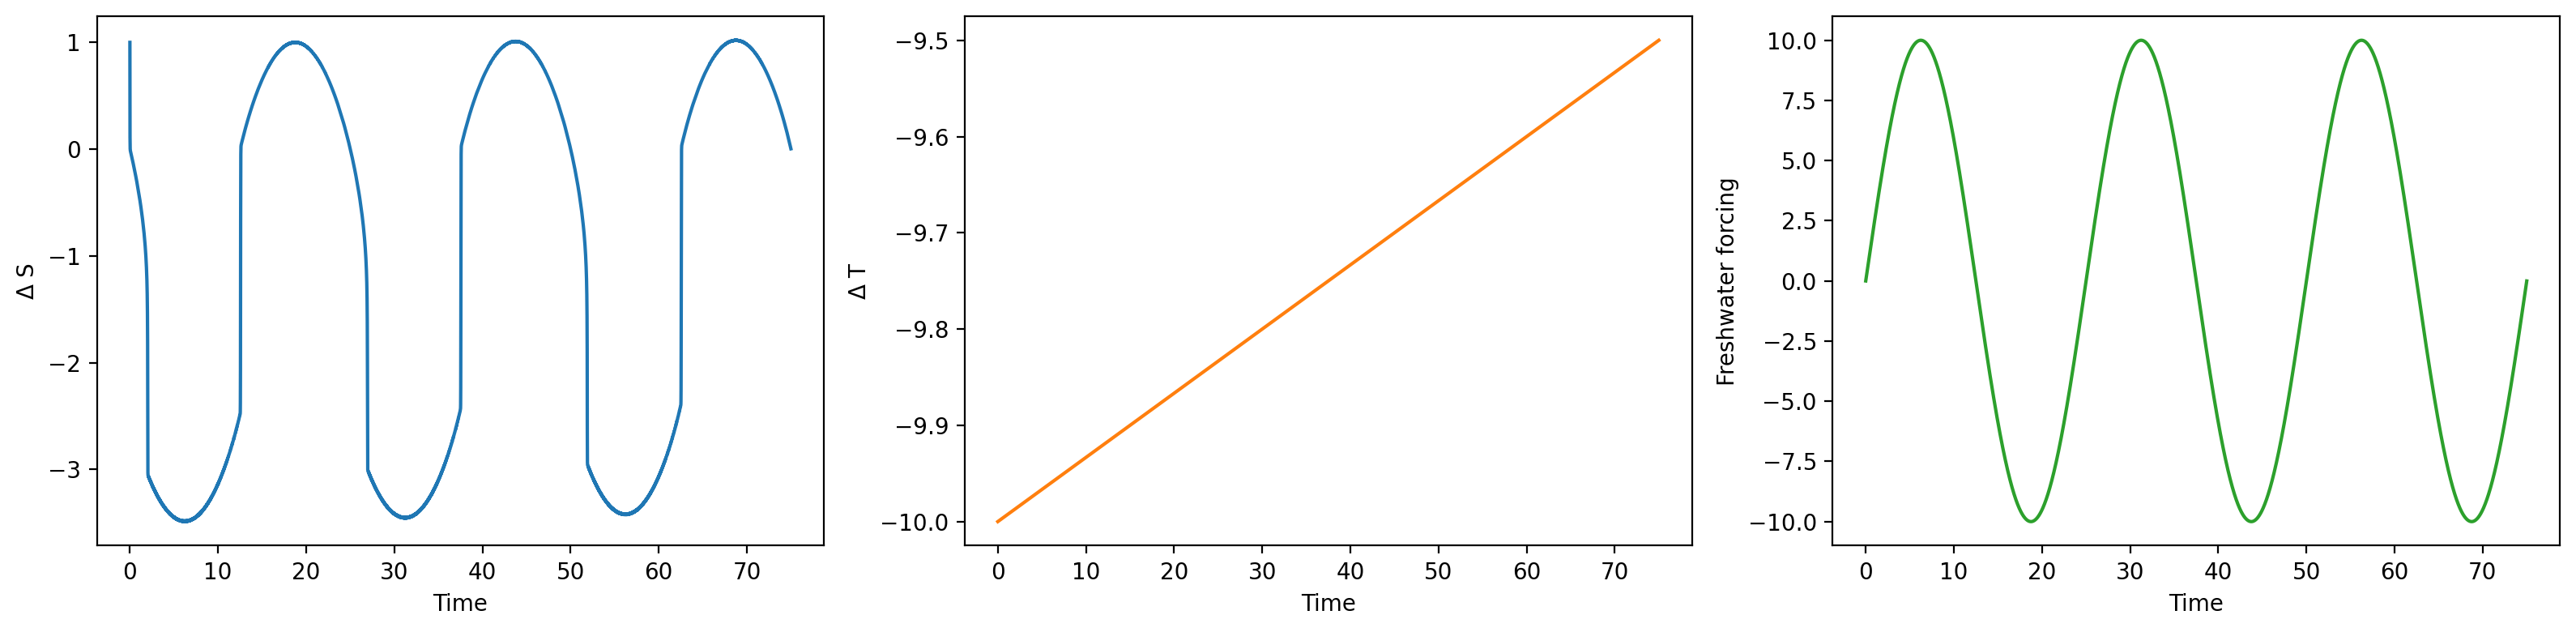

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(16,4), dpi=200);

ax[0].plot(input_data[:, 0], input_data[:, 1], color="tab:blue");
ax[0].set_xlabel('Time');
ax[0].set_ylabel('$\Delta$ S');

ax[1].plot(input_data[:, 0], input_data[:, 2], color="tab:orange");
ax[1].set_xlabel('Time');
ax[1].set_ylabel('$\Delta$ T');

ax[2].plot(input_data[:, 0], input_data[:, 3]/Fs_to_m_per_year, color="tab:green");
ax[2].set_xlabel('Time');
ax[2].set_ylabel('Freshwater forcing');

fig.tight_layout()
fig.savefig('figures/input_data_s.pdf');

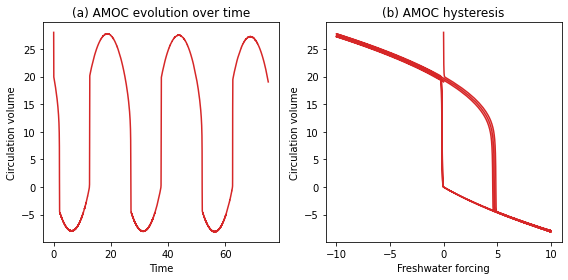

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Circulation Volume vs Time
ax[0].plot(input_data[:, 0], qplot/Sv, color="tab:red")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Circulation volume")
ax[0].set_title('(a) AMOC evolution over time')

# Circulation Volume vs Freshwater Forcing
ax[1].plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv, color="tab:red")
ax[1].set_xlabel("Freshwater forcing")
ax[1].set_ylabel("Circulation volume")
ax[1].set_title('(b) AMOC hysteresis')

fig.tight_layout()
fig.savefig('figures/qplot_s.pdf')
